In [59]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [2]:
from keras.preprocessing import image, sequence

In [60]:
from keras.preprocessing import image, sequence
from keras.applications import VGG16
from keras.layers import Dense, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector
from keras.models import Sequential, Model
from keras.optimizers import Nadam

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
import os

data_dir = '/content/drive/My Drive/Colab Notebooks/Flicker8k_Dataset/Flicker8k_Dataset'
files = os.listdir(data_dir)

In [63]:
print(files)

['1269470943_ba7fc49b4d.jpg', '1130401779_8c30182e3e.jpg', '1174629344_a2e1a2bdbf.jpg', '1095580424_76f0aa8a3e.jpg', '1067180831_a59dc64344.jpg', '1095590286_c654f7e5a9.jpg', '1007320043_627395c3d8.jpg', '1000268201_693b08cb0e.jpg', '1107246521_d16a476380.jpg', '1030985833_b0902ea560.jpg', '1087168168_70280d024a.jpg', '1019077836_6fc9b15408.jpg', '1403414927_5f80281505.jpg', '1378557186_4bd1da6834.jpg', '1321949151_77b77b4617.jpg', '1370773415_967b1ffde1.jpg', '1316247213_1d2c726dd5.jpg', '1357724865_4faf4e1418.jpg', '1363843090_9425d93064.jpg', '1348947380_14f0fc1237.jpg', '1338523142_57fce8229b.jpg', '1319634306_816f21677f.jpg', '1312020846_5abb4a9be2.jpg', '1361420539_e9599c60ae.jpg', '1303550623_cb43ac044a.jpg', '1141739219_2c47195e4c.jpg', '1197800988_7fb0ca4888.jpg', '1282392036_5a0328eb86.jpg', '1229756013_94663527d7.jpg', '1303548017_47de590273.jpg', '1204996216_71d7519d9a.jpg', '1227655020_b11a1bb112.jpg', '1478606153_a7163bf899.jpg', '1479679558_d0a01bc62b.jpg', '1473250020_d

In [64]:
images_dir = os.listdir("/content/drive/My Drive/Colab Notebooks/Flicker8k_Dataset/Flicker8k_Dataset/")

images_path = '/content/drive/My Drive/Colab Notebooks/Flicker8k_Dataset/Flicker8k_Dataset/'
captions_path = '/content/drive/My Drive/Colab Notebooks/Flickr8k_text/Flickr8k.token.txt'
train_path = '/content/drive/My Drive/Colab Notebooks/Flickr8k_text/Flickr_8k.trainImages-2.txt'
val_path = '/content/drive/My Drive/Colab Notebooks/Flickr8k_text/Flickr_8k.devImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_test = open(val_path, 'r').read().split("\n")

In [67]:
tokens = {}

for ix in range(len(captions)):
    temp = captions[ix].split("#")
    if len(temp) >= 2:
      if temp[0] in tokens:
          tokens[temp[0]].append(temp[1][2:])
      else:
          tokens[temp[0]] = [temp[1][2:]]

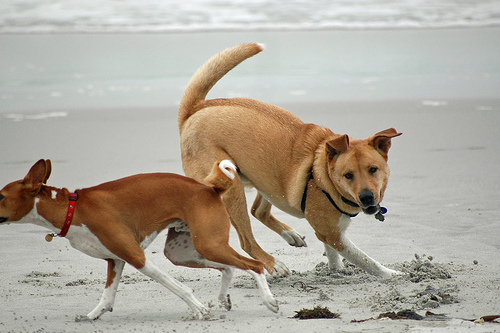

Two different breeds of brown and white dogs play on the beach .
Two dogs are making a turn on a soft sand beach .
Two dogs playing in the sand at the beach .
Two dogs playing together on a beach .
Two large tan dogs play along a sandy beach .


In [68]:
temp = captions[100].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [69]:
print ("Number of Training Images {}".format(len(x_train)))

Number of Training Images 797


In [70]:
vgg = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))

In [71]:
def preprocess_input(img):
    img = img[:, :, :, ::-1] #RGB to BGR
    img[:, :, :, 0] -= 103.939
    img[:, :, :, 1] -= 116.779
    img[:, :, :, 2] -= 123.68
    return img

In [72]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    im = preprocess_input(im)
    return im

In [73]:
x = preprocessing(images_path+temp[0])
print(x.shape)

(1, 224, 224, 3)


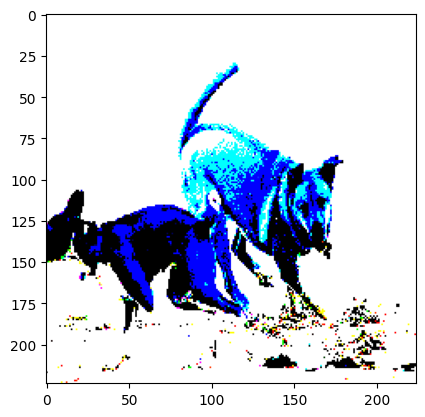

In [74]:
plt.figure(0)
plt.imshow(np.squeeze(x, axis=0))
plt.show()

In [75]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
vgg = Model(inputs=vgg.input, outputs=vgg.layers[-2].output)

In [77]:
vgg.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

# Encoding Images using VGG #

In [78]:
def get_encoding(model, img):
    image = preprocessing(images_path+img)
    pred = model.predict(image)
    pred = np.reshape(pred, pred.shape[1])
    return pred

In [79]:
print (temp[0])

print (get_encoding(vgg, temp[0]).shape)

1024138940_f1fefbdce1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
(4096,)


In [80]:
train_dataset = open('/content/drive/My Drive/Colab Notebooks/Flickr8k_text/flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('/content/drive/My Drive/Colab Notebooks/Flickr8k_text/flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

18

In [81]:
train_encoded_images = {}

c_train = 0
for img in x_train:
    train_encoded_images[img] = get_encoding(vgg, img)
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode('utf-8'))
        train_dataset.flush()
        c_train += 1
train_dataset.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/ste

In [ ]:
test_encoded_images = {}

c_test = 0
for img in x_test:
    test_encoded_images[img] = get_encoding(vgg, img)
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write(img+"\t"+caption+"\n")
        val_dataset.flush()
        c_test += 1
val_dataset.close()

In [84]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_encoded_images, pickle_f )

with open( "test_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(test_encoded_images, pickle_f )

# Building Vocabulary #

In [86]:
pd_dataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Flickr8k_text/flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print (ds.shape)

(3985, 2)


In [88]:
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])

print (len(sentences))

3985


In [89]:
words = [i.split() for i in sentences]

In [93]:
print (words[0])
print (len(words))

['<start>', 'A', 'blond', 'woman', 'is', 'throwing', 'a', 'stick', 'for', 'her', 'orange', 'dog', ',', 'who', 'is', 'leaping', 'to', 'get', 'it', '.', '<end>']
3985


In [94]:
unique = []
for i in words:
    unique.extend(i)

In [95]:
print (unique[:3])

['<start>', 'A', 'blond']


In [96]:
print (len(unique))

55773


In [98]:
unique = list(set(unique))
print (len(unique))

vocab_size = len(unique)

2994


In [99]:
#Vectorization
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [101]:
print (word_2_indices['<start>'])
print (indices_2_word[11])

2973
collar


In [103]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print (max_len)

40


# Creating Padded Sequences and Next Words #

In [106]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)

    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1

    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    #print(padded_sequences)
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print (padded_sequences.shape)
print (subsequent_words.shape)

Streaming output truncated to the last 5000 lines.
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [2973,  974,  623,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [2973,  974,  623, 1430,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [2973,  974,  623, 1430, 1684,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
     

KeyboardInterrupt: 

In [107]:
print (padded_sequences[0])

[[2973    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2973  532    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2973  532 2781    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2973  532 2781 2898    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2973  532 2781 2898 2693    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [109]:
for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print (indices_2_word[padded_sequences[0][ix][iy]]),
    print ("\n")

print (len(padded_sequences[0]))

<start>
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound


<start>
A
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound


<start>
A
blond
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
greyhound
gr

In [110]:
with open('./train_encoded_images.p', 'rb') as f:
        encoded_images = pickle.load(f)

In [112]:
imgs = []

for ix in range(ds.shape[0]):
    imgs.append(encoded_images[ds[ix, 0]])

imgs = np.asarray(imgs)
print (imgs.shape)

(3985, 4096)


In [113]:
number_of_images = 1500

In [116]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

num_images_to_process = min(number_of_images, len(padded_sequences))

for ix in range(num_images_to_process):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("./captions.npy", captions)
np.save("./next_words.npy", next_words)

print (captions.shape)
print (next_words.shape)

(16508, 40)
(16508, 2994)


In [118]:
images = []

for ix in range(num_images_to_process):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])

images = np.asarray(images)

np.save("./images.npy", images)

print (images.shape)

(16508, 4096)


In [120]:
image_names = []

for ix in range(num_images_to_process):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])

image_names = np.asarray(image_names)

np.save("./image_names.npy", image_names)

print (len(image_names))

16508
